In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install scikeras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

from scikeras.wrappers import KerasClassifier

import torch
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T

import os

import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.cm as cm

from sklearn.model_selection import RandomizedSearchCV


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!ls

COVID-19_Radiography_Dataset.zip  sample_data


In [7]:
pwd

'/content'

In [8]:
!unzip COVID-19_Radiography_Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
 

In [9]:
!ls
import shutil

COVID-19_Radiography_Dataset  COVID-19_Radiography_Dataset.zip	sample_data


In [10]:
#Get Data From Zip

!pwd


#Remove Masks in Datasets https://pynative.com/python-delete-files-and-directories/#h-delete-a-non-empty-directory-using-shutil
classes = ['COVID','Lung_Opacity','Normal','Viral Pneumonia']
for i in classes:

  shutil.rmtree(f'/content/COVID-19_Radiography_Dataset/{i}/masks')



/content


# Keras CNN

In [11]:
train_ds = image_dataset_from_directory(
    directory = '/content/COVID-19_Radiography_Dataset',
    image_size=(256,256),
    batch_size=256,
    seed=42,
    validation_split=0.1,
    shuffle = True,
    subset='training',
)

val_ds = image_dataset_from_directory(
    directory = '/content/COVID-19_Radiography_Dataset',
    image_size=(256,256),
    batch_size=256,
    seed=42,
    validation_split=0.1,
    shuffle = True,
    subset='validation',
)

# tts on training only, use test data as blind

# save model as MODEL object with train data, then load in test data (pickle, keras method)

Found 21165 files belonging to 4 classes.
Using 19049 files for training.
Found 21165 files belonging to 4 classes.
Using 2116 files for validation.


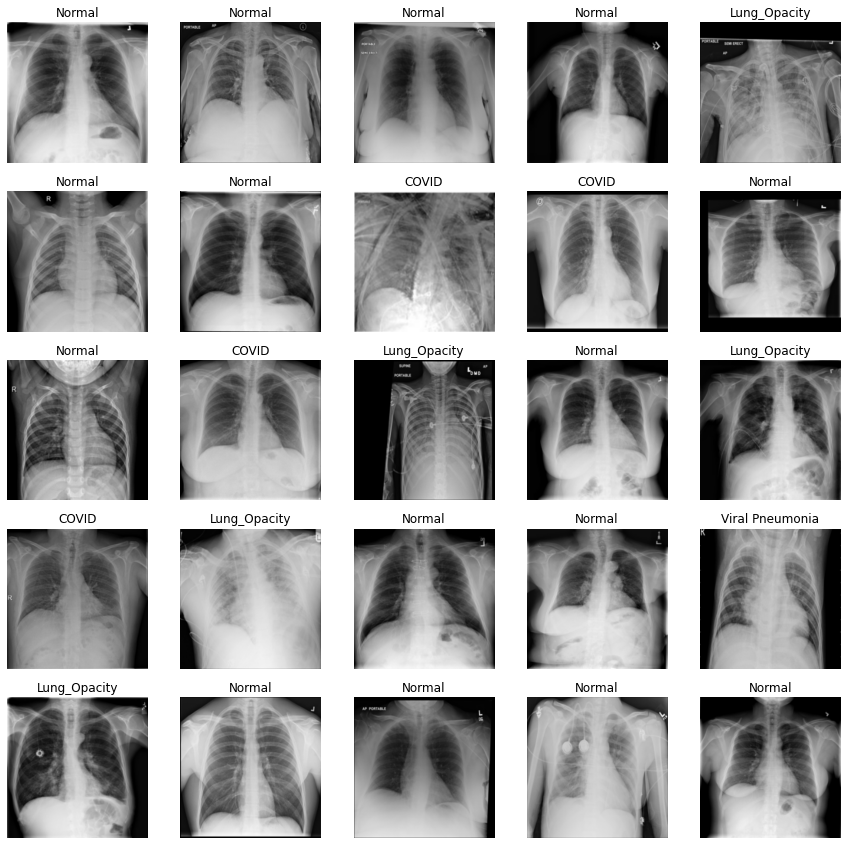

In [12]:
class_names = train_ds.class_names

plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
  for i in range(25):
    ax = plt.subplot(5,5 , i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [ ]:
model = Sequential()
model.add(Rescaling(1./255,input_shape = (256,256,3)))
model.add(Conv2D(16,3,padding='same',activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, padding='same', activation='relu'),)
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, padding='same', activation='relu'),)
model.add(MaxPooling2D())
model.add(Dropout(0.35))

model.add(Conv2D(64, 3, padding='same', activation='relu'),)
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(128,activation = 'relu',kernel_regularizer = l2(0.001)))
model.add(Dense(4,activation='softmax'))

# Had an error of None,1 not matching None,4, image_from_directory returns the output as a sparse matrix
# credits to https://www.kaggle.com/general/197993
model.compile(optimizer ='adam',loss ='sparse_categorical_crossentropy',metrics =['acc'])

In [ ]:
h = model.fit(train_ds, validation_data = val_ds, epochs=5)

Epoch 1/5
75/75 [==============================] - 840s 11s/step - loss: 1.0693 - acc: 0.6061 - val_loss: 0.7889 - val_acc: 0.7330
Epoch 2/5
75/75 [==============================] - 835s 11s/step - loss: 0.6590 - acc: 0.7778 - val_loss: 0.6359 - val_acc: 0.7921
Epoch 3/5
75/75 [==============================] - 836s 11s/step - loss: 0.5329 - acc: 0.8240 - val_loss: 0.5575 - val_acc: 0.8105
Epoch 4/5
75/75 [==============================] - 828s 11s/step - loss: 0.4676 - acc: 0.8440 - val_loss: 0.5079 - val_acc: 0.8223
Epoch 5/5
75/75 [==============================] - 823s 11s/step - loss: 0.4090 - acc: 0.8680 - val_loss: 0.4217 - val_acc: 0.8549


In [ ]:
preds = model.predict(val_ds)

9/9 [==============================] - 27s 3s/step


# Pytorch

In [70]:
%matplotlib inline
import random
import torch
import torchvision
from PIL import Image

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.13.1+cu116


In [76]:
# based on pytorch resnet tutorial: https://www.kaggle.com/code/arunmohan003/pytorch-transfer-learning-resnet18

root_dir = "COVID-19_Radiography_Dataset"
source_dirs= ["Normal/images", "Viral Pnemuonia/images", "COVID/images", 'Sick/images']

class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid', 'sick']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

In [77]:
train_transform = torchvision.transforms.Compose([
                                                  torchvision.transforms.Resize(size = (300,300)),
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize(mean = [0.485,0.456,0.406], std = [0.229, 0.224, 0.225])
])


test_transform = torchvision.transforms.Compose([
                                                  torchvision.transforms.Resize(size = (300,300)),
                                                 
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize([0.485,0.456,0.406], [0.229, 0.224, 0.225])
])

In [78]:
!ls

COVID-19_Radiography_Dataset  COVID-19_Radiography_Dataset.zip	sample_data


In [79]:
train_dirs = {
    "normal" : "COVID-19_Radiography_Dataset/Normal/images",
    "viral" : "COVID-19_Radiography_Dataset/Viral Pneumonia/images",
    "covid" : "COVID-19_Radiography_Dataset/COVID/images",
    'sick' : "COVID-19_Radiography_Dataset/Lung_Opacity/images"
}
train_dataset = ChestXRayDataset(train_dirs, train_transform)

training_data_size = 0.8

train_size = int(training_data_size * len(train_dataset))
test_size = len(train_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [train_size, test_size])

print("Length of train set   :  ", len(train_dataset))
print("Length of test set    :  ", len(test_dataset))

Found 10192 normal examples
Found 1345 viral examples
Found 3616 covid examples
Found 6012 sick examples
Length of train set   :   16932
Length of test set    :   4233


In [80]:
batch_size = 10

data_train_len = torch.utils.data.DataLoader(train_dataset, batch_size= batch_size, shuffle = True)
data_test_len = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


print("Length of training batches", len(data_train_len))
print("Lentgth of test batches", len(data_test_len))

Length of training batches 1694
Lentgth of test batches 424


In [95]:
class_names = ["Normal", "Viral Pneumonia","Covid", "Cardio Dis."]

def show_images(images,labels,preds):
    plt.figure(figsize=(15,7))
    for i , image in enumerate(images):
        plt.subplot(1,11,i+1, xticks = [], yticks= [])
        image = image.numpy().transpose((1,2,0))
        mean = np.array([0.5, 0.5, 0.4])
        std = np.array([0.2, 0.2, 2])
        image = image*std + mean
        image = np.clip(image,0.,1.)
        plt.imshow(image)
        
        colorr = "green"
        if(preds[i] != labels[i]):
            
            colorr="red"
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=colorr)
    plt.tight_layout()
    plt.show()
    
def test_predicts():
    resnet18.eval()
    images, labels = next(iter(data_test_len))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)
        

In [97]:
resnet18 = torchvision.models.resnet18(pretrained=True)
print(resnet18)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [1]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(data_test_len):
            optimizer.zero_grad()
            
            outputs = resnet18(images)
            
            loss = loss_fn(outputs, labels)
            
            loss.backward()
            
            optimizer.step()
            train_loss += loss.item()
            
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(data_test_len):
                    
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

                test_predicts()

                resnet18.train()

                if accuracy >= 0.98:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

#        print(f'Training Loss: {train_loss:.4f}')
#    print('Training complete..')

In [2]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=4)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

NameError: ignored

Starting training..
Starting epoch 1/4
Evaluating at step 0
Validation Loss: 1.3713, Accuracy: 0.2858


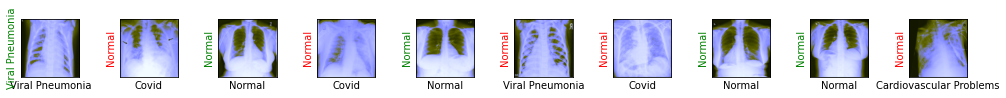

Evaluating at step 20
Validation Loss: 0.9819, Accuracy: 0.6154


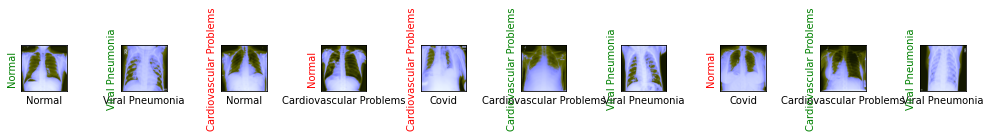

Evaluating at step 40
Validation Loss: 0.7351, Accuracy: 0.6877


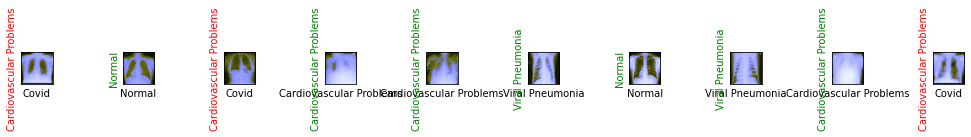

Evaluating at step 60
Validation Loss: 0.5415, Accuracy: 0.7983


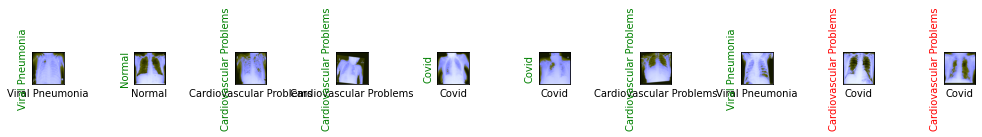

Evaluating at step 80
Validation Loss: 0.4255, Accuracy: 0.8637


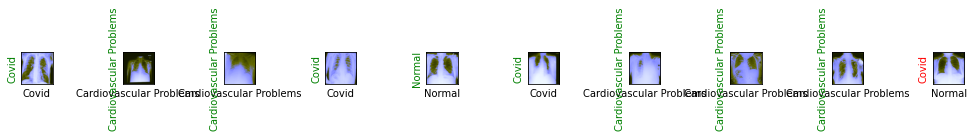

Evaluating at step 100
Validation Loss: 0.3699, Accuracy: 0.8698


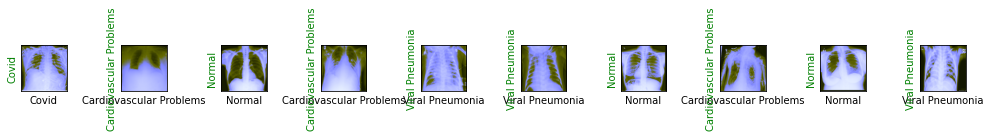

Evaluating at step 120
Validation Loss: 0.3500, Accuracy: 0.8842


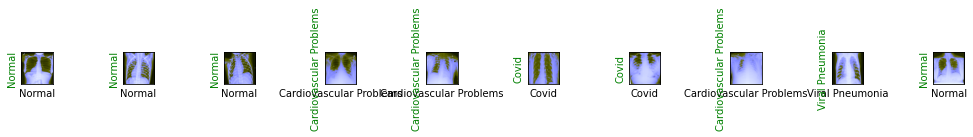

Evaluating at step 140
Validation Loss: 0.3301, Accuracy: 0.8854


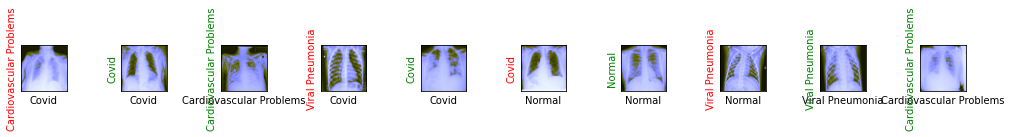

Evaluating at step 160
Validation Loss: 0.3049, Accuracy: 0.8949


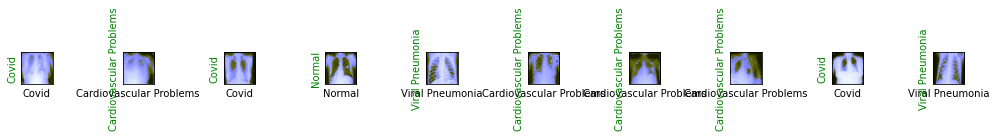

Evaluating at step 180
Validation Loss: 0.2867, Accuracy: 0.9031


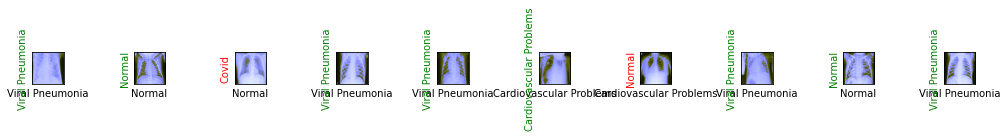

Evaluating at step 200
Validation Loss: 0.2875, Accuracy: 0.8984


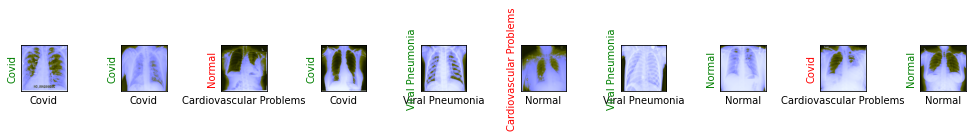

Evaluating at step 220
Validation Loss: 0.2585, Accuracy: 0.9142


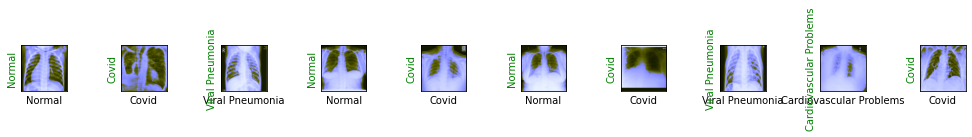

Evaluating at step 240
Validation Loss: 0.2330, Accuracy: 0.9256


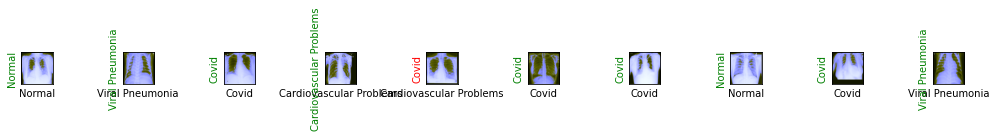

Evaluating at step 260
Validation Loss: 0.2509, Accuracy: 0.9159


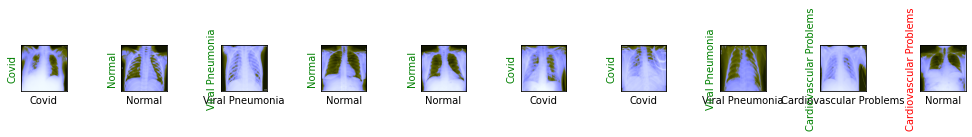

Evaluating at step 280
Validation Loss: 0.2602, Accuracy: 0.9121


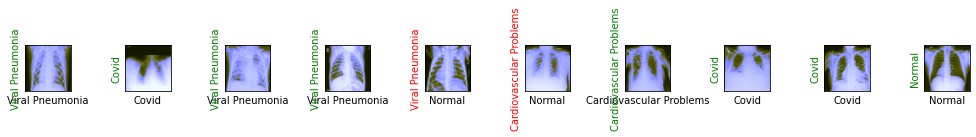

Evaluating at step 300
Validation Loss: 0.2190, Accuracy: 0.9263


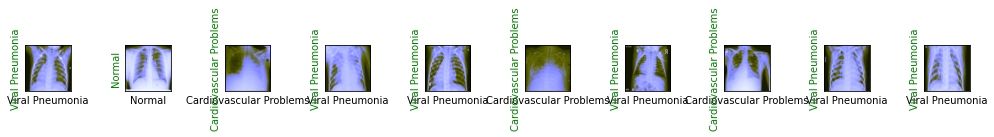

Evaluating at step 320
Validation Loss: 0.1958, Accuracy: 0.9341


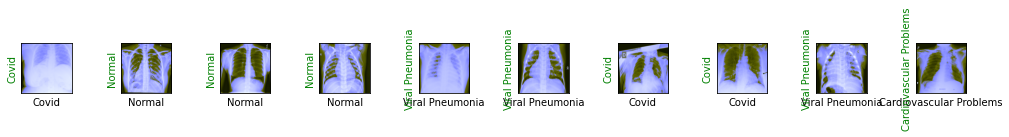

Evaluating at step 340
Validation Loss: 0.2301, Accuracy: 0.9185


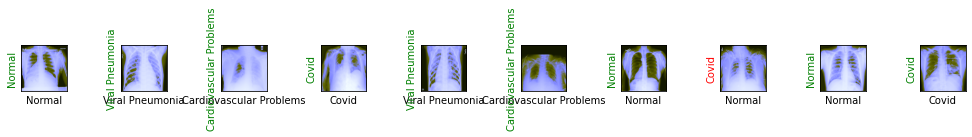

Evaluating at step 360
Validation Loss: 0.1853, Accuracy: 0.9435


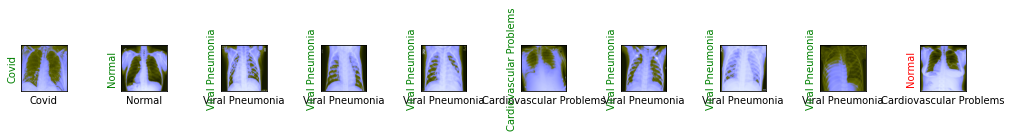

Evaluating at step 380
Validation Loss: 0.2033, Accuracy: 0.9329


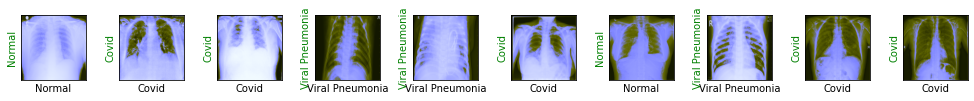

Evaluating at step 400
Validation Loss: 0.1784, Accuracy: 0.9402


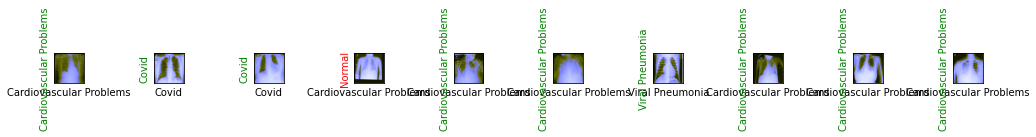

Evaluating at step 420
Validation Loss: 0.1673, Accuracy: 0.9445


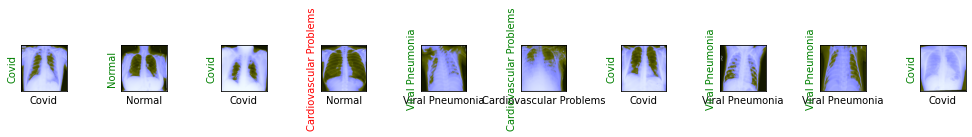

Training Loss: 0.4346
Starting epoch 2/4
Evaluating at step 0
Validation Loss: 0.1819, Accuracy: 0.9367


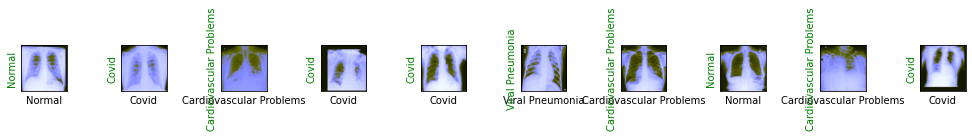

Evaluating at step 20
Validation Loss: 0.1725, Accuracy: 0.9407


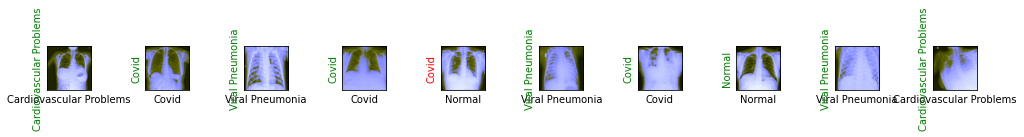

Evaluating at step 40
Validation Loss: 0.1995, Accuracy: 0.9268


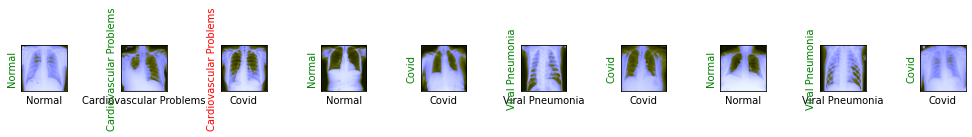

Evaluating at step 60
Validation Loss: 0.1726, Accuracy: 0.9421


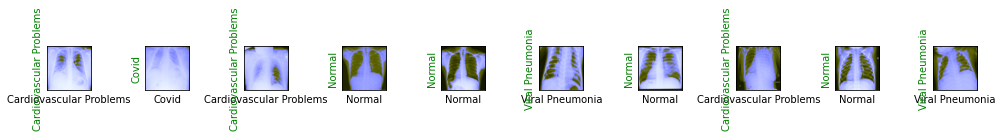

Evaluating at step 80
Validation Loss: 0.2015, Accuracy: 0.9324


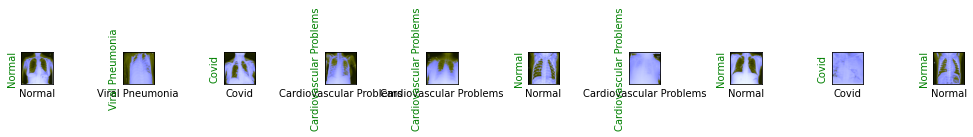

Evaluating at step 100
Validation Loss: 0.2213, Accuracy: 0.9216


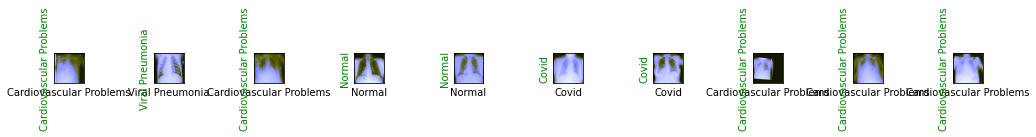

Evaluating at step 120
Validation Loss: 0.1629, Accuracy: 0.9435


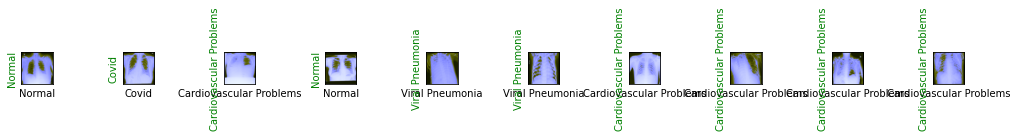

Evaluating at step 140
Validation Loss: 0.1853, Accuracy: 0.9386


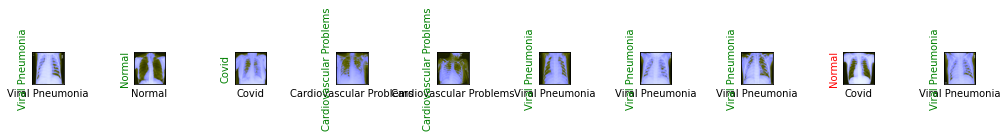

Evaluating at step 160
Validation Loss: 0.1513, Accuracy: 0.9499


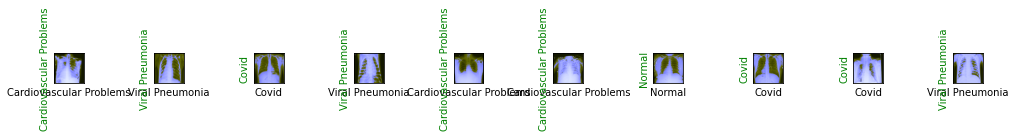

Evaluating at step 180
Validation Loss: 0.1491, Accuracy: 0.9544


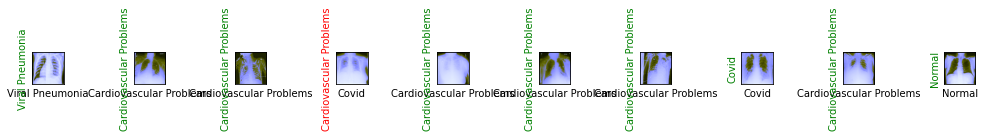

Evaluating at step 200
Validation Loss: 0.1715, Accuracy: 0.9350


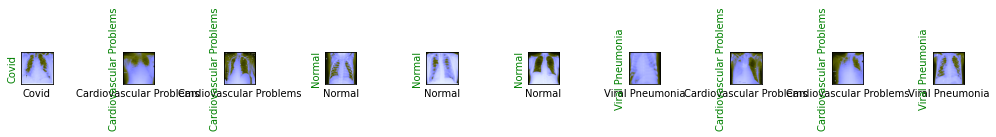

Evaluating at step 220
Validation Loss: 0.1551, Accuracy: 0.9483


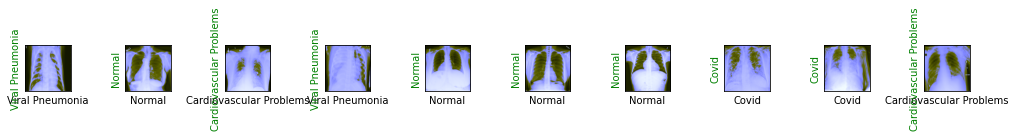

Evaluating at step 240


In [ ]:
train(epochs = 4)